In [ ]:
from google.colab import files
uploaded = files.upload()

Saving commodity_futures.csv to commodity_futures.csv


Datos cargados y convertidos a series de tiempo.
            NATURAL GAS   GOLD  WTI CRUDE  BRENT CRUDE  SOYBEANS    CORN  \
Date                                                                       
2000-01-03          NaN    NaN        NaN          NaN    456.50  200.75   
2000-01-04        2.176  283.7      25.55        24.39    464.25  203.00   
2000-01-05        2.168  282.1      24.91        23.73    469.25  203.00   
2000-01-06        2.196  282.4      24.78        23.62    468.00  203.75   
2000-01-07        2.173  282.9      24.22        23.09    471.50  207.00   

            COPPER  SILVER  LOW SULPHUR GAS OIL  LIVE CATTLE  ...     ZINC  \
Date                                                          ...            
2000-01-03     NaN     NaN                  NaN       69.700  ...  1237.50   
2000-01-04  0.8480   5.375               213.50       69.075  ...  1215.00   
2000-01-05  0.8565   5.210               213.00       68.975  ...  1209.25   
2000-01-06  0.8530   5.167  

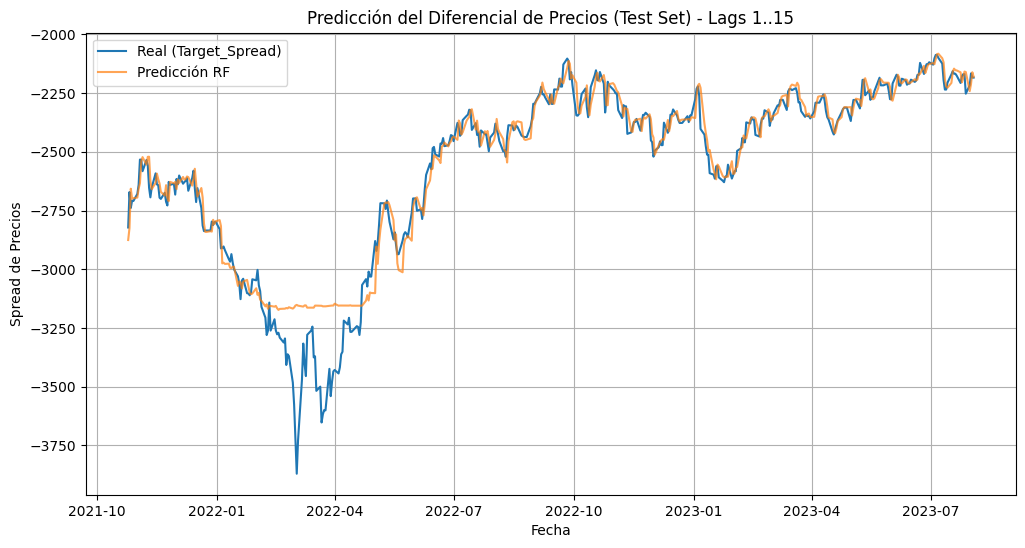


--- Evaluación del Baseline (Last Value) ---
RMSE: 49.7445
MAE: 34.8561
R2: 0.9830

Iniciando predicción Walk-Forward con ARIMA (2,1,1)...

--- Evaluación del Modelo ARIMA ---
RMSE: 86.4382
MAE: 54.0159
R2: 0.9486

           RESUMEN COMPARATIVO DE MODELOS
                          Modelo     RMSE     MAE     R2
           Baseline (Last Value)  49.7445 34.8561 0.9830
         ARIMA (2,1,1) Regressor  86.4382 54.0159 0.9486
Random Forest Regressor (Óptimo) 102.8022 56.3444 0.9272


In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt
import statsmodels.api as sm
from math import sqrt
import warnings
warnings.filterwarnings("ignore")

# --- 1. Carga y Preparación Inicial de Datos ---
df = pd.read_csv('commodity_futures.csv')
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)

print("Datos cargados y convertidos a series de tiempo.")
print(df.head())
print("\nInformación de nulos inicial:")
print(df.isnull().sum())

# --- 2. Manejo de Valores Faltantes (ffill) ---
df.fillna(method='ffill', inplace=True)
print("\nNulos después de ffill:")
print(df.isnull().sum().sum())

# --- 3. Feature Engineering ---
# Variable objetivo: diferencial Cobre - Aluminio al día siguiente
df['Spread_Cu_Al'] = df['COPPER'] - df['ALUMINIUM']
df['Target_Spread'] = df['Spread_Cu_Al'].shift(-1)
df.dropna(subset=['Target_Spread'], inplace=True)
print("\nVariable objetivo (Target_Spread) creada.")

# Parámetros nuevos: LAGS hasta 15 y ventana MA = 15
n_lags = 15
window = 15

# Crear lags para las mismas variables que usaste antes (Spread, COPPER, GOLD)
for lag in range(1, n_lags + 1):
    df[f'Lag_{lag}_Spread'] = df['Spread_Cu_Al'].shift(lag)
    df[f'Lag_{lag}_Copper'] = df['COPPER'].shift(lag)
    df[f'Lag_{lag}_USD'] = df['GOLD'].shift(lag)

# Medias móviles y volatilidad usando ventana de 15 días
df['MA_Spread'] = df['Spread_Cu_Al'].rolling(window=window).mean()
df['Volatilidad_Spread'] = df['Spread_Cu_Al'].rolling(window=window).std()
df['Ratio_Spread_MA'] = df['Spread_Cu_Al'] / df['MA_Spread']
df['MA_Copper'] = df['COPPER'].rolling(window=window).mean()

# Limpieza final (elimina NaN generados por lags y rollings)
df.dropna(inplace=True)
print(f"Dataset final con {len(df)} filas después de Feature Engineering y limpieza.")
print(df.tail())

# --- 4. División de Datos Cronológica (80/10/10) ---
data_size = len(df)
train_size = int(0.80 * data_size)
validation_size = int(0.10 * data_size)
test_size = data_size - train_size - validation_size

train_df = df.iloc[:train_size]
validation_df = df.iloc[train_size : train_size + validation_size]
test_df = df.iloc[train_size + validation_size :]

# Definición de X (Features) y Y (Target)
features = [col for col in df.columns if col not in ['Target_Spread', 'Spread_Cu_Al']]
X_train, y_train = train_df[features], train_df['Target_Spread']
X_val, y_val = validation_df[features], validation_df['Target_Spread']
X_test, y_test = test_df[features], test_df['Target_Spread']

print(f"\nConjunto de Entrenamiento (80%): {len(X_train)} días (datos más antiguos)")
print(f"Conjunto de Validación (10%): {len(X_val)} días")
print(f"Conjunto de Prueba (10%): {len(X_test)} días (datos más recientes)")

# --- 5. Estandarización de Características ---
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

X_train_scaled = pd.DataFrame(X_train_scaled, index=X_train.index, columns=X_train.columns)
X_val_scaled = pd.DataFrame(X_val_scaled, index=X_val.index, columns=X_val.columns)
X_test_scaled = pd.DataFrame(X_test_scaled, index=X_test.index, columns=X_test.columns)

# --- 6. Ajuste de Modelo: Random Forest Regressor ---
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [5, 10, None],
    'min_samples_split': [2, 5],
    'max_features': ['sqrt', 0.8]
}

tscv = TimeSeriesSplit(n_splits=5)
rf_model = RandomForestRegressor(random_state=42)

print("\nIniciando Grid Search con Validación Cruzada Expansiva...")
grid_search = GridSearchCV(
    estimator=rf_model,
    param_grid=param_grid,
    cv=tscv,
    scoring='neg_mean_squared_error',
    verbose=1,
    n_jobs=-1
)

grid_search.fit(X_train_scaled, y_train)
best_params = grid_search.best_params_
best_score = grid_search.best_score_
final_rf_model = grid_search.best_estimator_

print("--- Resultados del Grid Search ---")
print(f"Mejores Hiperparámetros: {best_params}")
print(f"Mejor RMSE (en CV): {sqrt(-best_score):.4f}")
print("-----------------------------------")

# --- 7. Evaluación Final del Modelo ---
y_pred_test = final_rf_model.predict(X_test_scaled)

rmse = sqrt(mean_squared_error(y_test, y_pred_test))
mae = mean_absolute_error(y_test, y_pred_test)
r2 = r2_score(y_test, y_pred_test)

print("\n--- Métricas de Desempeño en el Conjunto de Prueba ---")
print(f"Raíz del Error Cuadrático Medio (RMSE): {rmse:.4f}")
print(f"Error Absoluto Medio (MAE): {mae:.4f}")
print(f"Coeficiente de Determinación (R²): {r2:.4f}")
print("-------------------------------------------------------")

# Importancia de variables
importances = final_rf_model.feature_importances_
feature_names = X_train.columns

feature_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

print("\n--- Top 20 Variables más Importantes ---")
print(feature_importance_df.head(20))

# Visualización de la Predicción
plt.figure(figsize=(12, 6))
plt.plot(y_test.index, y_test.values, label='Real (Target_Spread)')
plt.plot(y_test.index, y_pred_test, label='Predicción RF', alpha=0.7)
plt.title('Predicción del Diferencial de Precios (Test Set) - Lags 1..15')
plt.xlabel('Fecha')
plt.ylabel('Spread de Precios')
plt.legend()
plt.grid(True)
plt.show()

# Función de Evaluación
def evaluate_model(y_true, y_pred, model_name):
    rmse = sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    results = {
        'Modelo': model_name,
        'RMSE': rmse,
        'MAE': mae,
        'R2': r2
    }
    return results

# Baseline (Last Value)
y_pred_baseline = test_df['Spread_Cu_Al'].values
baseline_results = evaluate_model(y_test, y_pred_baseline, "Baseline (Last Value)")

print("\n--- Evaluación del Baseline (Last Value) ---")
print(f"RMSE: {baseline_results['RMSE']:.4f}")
print(f"MAE: {baseline_results['MAE']:.4f}")
print(f"R2: {baseline_results['R2']:.4f}")

# ARIMA (walk-forward) usando 'Spread_Cu_Al' historia
y_train_arima = train_df['Spread_Cu_Al']
y_test_arima = test_df['Spread_Cu_Al']
order = (2, 1, 1)

y_pred_arima = []
history = [x for x in y_train_arima.values]

print("\nIniciando predicción Walk-Forward con ARIMA (2,1,1)...")
for t in range(len(y_test_arima)):
    try:
        model = sm.tsa.arima.ARIMA(history, order=order)
        model_fit = model.fit()
        yhat = model_fit.forecast(steps=1)[0]
        y_pred_arima.append(yhat)
        obs = y_test_arima.values[t]
        history.append(obs)
    except Exception as e:
        y_pred_arima.append(history[-1])

arima_results = evaluate_model(y_test.values, y_pred_arima, "ARIMA (2,1,1) Regressor")

print("\n--- Evaluación del Modelo ARIMA ---")
print(f"RMSE: {arima_results['RMSE']:.4f}")
print(f"MAE: {arima_results['MAE']:.4f}")
print(f"R2: {arima_results['R2']:.4f}")

# Resumen comparativo
rf_results = {
    'Modelo': 'Random Forest Regressor (Óptimo)',
    'RMSE': rmse,
    'MAE': mae,
    'R2': r2
}

final_summary = pd.DataFrame([rf_results, baseline_results, arima_results])
final_summary = final_summary.sort_values(by='RMSE')

print("\n=======================================================")
print("           RESUMEN COMPARATIVO DE MODELOS")
print("=======================================================")
print(final_summary.to_string(index=False, float_format="%.4f"))
print("=======================================================")